In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# last conscious update: 06/11/2023
# CIJA

The below text and code have extracts and adapatations from the following websites:

https://ademos.people.uic.edu/Chapter23.html

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# TIME SERIES ANALYSIS WITH ARIMA

A time series is a sequence where a metric is recorded over regular time intervals.

Depending on the frequency, a time series can be of yearly (ex: annual budget), quarterly (ex: expenses), monthly (ex: air traffic), weekly (ex: sales qty), daily (ex: weather), hourly (ex: stocks price), minutes (ex: inbound calls in a call canter) and even seconds wise (ex: web traffic).

“time series data” = data that is made up of a sequence of data points taken at successive equally spaced points in time.

ARIMA stands for auto-regressive integrated moving average. It’s a way of modelling time series data for forecasting (i.e., for predicting future points in the series), in such a way that:

* a pattern of growth/decline in the data is accounted for (hence the “auto-regressive” part)
* the rate of change of the growth/decline in the data is accounted for (hence the “integrated” part)
* noise between consecutive time points is accounted for (hence the “moving average” part)

The formula itself for the ARIMA model looks like this:

$Y_t = c + \phi_{1} y_{d_{t-1}} + \dots + \phi_{p} y_{d_{t-p}} + \theta_1 e_{t-1} + \dots + \theta_q e_{t-q} + e_t$

where $e$ is an error term and $c$ is a constant

ARIMA models are typically expressed like “ARIMA(p,d,q)”, with the three terms p, d, and q defined as follows:

* p means the number of preceding (“lagged”) Y values that have to be added/subtracted to Y in the model, so as to make better predictions based on local periods of growth/decline in our data. This captures the “autoregressive” nature of ARIMA.

* d represents the number of times that the data have to be “differenced” to produce a stationary signal (i.e., a signal that has a constant mean over time). This captures the “integrated” nature of ARIMA. If d=0, this means that our data does not tend to go up/down in the long term (i.e., the model is already “stationary”). In this case, then technically you are performing just ARMA, not AR-I-MA. If p is 1, then it means that the data is going up/down linearly. If p is 2, then it means that the data is going up/down exponentially. More on this below…

* q represents the number of preceding/lagged values for the error term that are added/subtracted to Y. This captures the “moving average” part of ARIMA.

## Understanding the ARIMA model

let's talk a bit more about the components of the ARIMA model.

### AR part

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’. 

$Y_t = \alpha + \beta_1 Y_{t-1} + \dots + \beta_p Y_{t-p} + e_1$

where, $Y_{t-1}$ is the lag 1 of the series, $\beta_1$ is the coefficient of the lag 1 that the model estimates, and $\alpha$ is the intercept term, also estimated by the model. 

Given that there are p past values, this is denoted as AR(p) or an autoregressive model of the order p. $e_1$ indicates the white noise 

### MA part

Likewise, a pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

$Y_t = c + e_t + \theta_1 e_{t-1} + \dots + \theta_q e_{t-q}$

Here, the future value $Y_t$ is computed based on the errors $e_t$ made by the previous model. So, each successive term looks one step further into the past to incorporate the mistakes made by that model in the current computation. Based on the window we are willing to look past, the value of q is set. Thus, the above model can be independently denoted as a moving average order q or simply MA(q).

### I part

Autoregressive models are conceptually similar to linear regression, the assumptions made by the latter hold here as well. Time series data must be made stationary to remove any obvious correlation and collinearity with the past data. In stationary time-series data, the properties or value of a sample observation does not depend on the timestamp at which it is observed. For example, given a hypothetical dataset of the year-wise population of an area, if one observes that the population increases two-fold each year or increases by a fixed amount, then this data is non-stationary. Any given observation is highly dependent on the year since the population value would rely on how far it is from an arbitrary past year. This dependency can induce incorrect bias while training a model with time-series data.

Usually, using non-stationary time series in regression models can lead to a high R-squared value and statistically significant regression coefficients. These results are very likely misleading or spurious, because there is probably no real relationship between them and the only common thing is that they’re growing (declining) over time. 

To remove this correlation, ARIMA uses differencing to make the data stationary. Differencing, at its simplest, involves taking the difference of two adjacent data points.

differencing can be simply modelled by:

$y'_t = y_t - y_{t-1} = y_t - By_t = (1 - B)y_t$

where $B$ denotes the backshift operator defined as:

$B y_t = y_{t - 1}$

However, differencing to create stationary data might not always be so straightforward. Multiple iterations of differencing can help more to an extent if required. Differencing the data d times creates a d-order differenced data.

If d=2, then:

$y''_t = y'_t - y'_{t-1} $

$= (y_t - y_{t-1}) - (y_{t-1}- y_{t-2} )$

$= y_t - 2y_{t-1} + y_{t-2}$

or 

$y''_t = y_t - 2y_{t-1} + y_{t-2} = (1 - 2B - B^2)y_t = (1-B^2)y_t$,

in general, a d-order differenced series would be defined as:

$y_d = (1-B)^d y_t$

## ARIMA model

Combining all together we obtain the ARIMA model as expressed above and repeated here:

$Y_t = c + \phi_{1} y_{d_{t-1}} + \dots + \phi_{p} y_{d_{t-p}} + \theta_1 e_{t-1} + \dots + \theta_q e_{t-q} + e_t$

As far as the parameters $c$, $\phi$, and $\theta$ are concerned, they are updated using maximum likelihood estimation (MLE), just like in linear regression. However, unlike linear regression, estimating and forecasting a time series using ARIMA, we can generate a vast range of future predictions based on a single trained model without any external data during inference.

## An example ARIMA model for manually generated data

We will use manually generated made of two different sines waves that go up exponentially. So we can know the trend and frequency of our data and compare to the results obtained by the ARIMA model.

Recall the equation for a sine wave:

$Y(t) = A \sin(2 \pi f  t + \phi)$

* $Y(t)$ means the value of the wave at time t
* $A$ means the amplitude, or the peak deviation of the function from zero. (Basically, how high or low the wave goes)
* $f$ means the ordinary frequency, or the number of oscillations (cycles) that occur at each second of time. In other words, this is how “wide” or “narrow” the sine wave is.
* Greek letter $\phi$ (that rightmost symbol) means the phase, which specifies (in radians) where in its cycle the oscillation is at t = 0. In other words, this refers to what point in the wave we start at, at time point zero.

let's generate our sin waves

In [37]:
# generate data

np.random.seed(10) # set a seed for reproducibility

L = 100 # length of time series
t = np.linspace(0, 4*np.pi, L) # sequence of L numbers going up by intervals of 4*pi.
e_unif = np.random.rand(len(t)) # L data points of uniform error
e_normal = np.random.standard_normal(len(t)) # L data points of  Gaussian/normal error

sine_1 = 30 * np.sin(2*t) + e_unif*1.5
sine_2 = 20 * np.sin(5*t + 2) + e_unif*1.5

two_sines = sine_1 + sine_2

line_going_up = np.arange(0.5, 50.5, 0.5)
exponential_line = (3/5000000) * line_going_up**5

two_sines_going_up_exponentially = two_sines + exponential_line

tseries = two_sines_going_up_exponentially

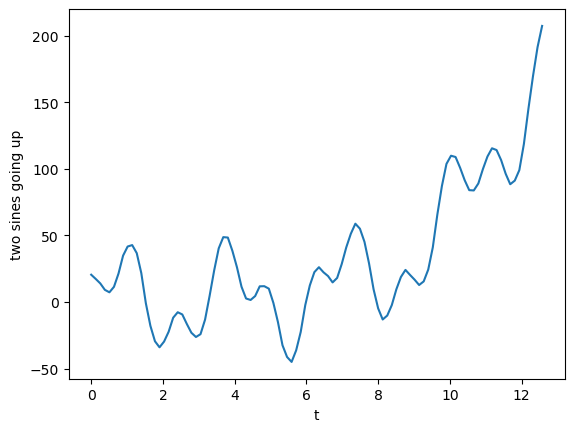

In [4]:
plt.plot(t,tseries)
plt.xlabel('t')
plt.ylabel('two sines going up')
plt.show()

## MANUAL ANALYSIS TO FIND BEST ARIMA MODEL

## Determine the value of d

The value of d is determined by the number of times a time series has to be differenced to be stationary. This can be determined by visual inspection or using statiscal tests. We will use the Augmented Dickey-Fuller (ADF) test.

In [5]:
# Check if data is stationary (if the data is steady over time ( -- ), i.e. does not have grow ( / ) or decline  ( \ ) patterns)

result = adfuller(tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.669847
p-value: 1.000000
Critical Values:
	1%: -3.508
	5%: -2.895
	10%: -2.585


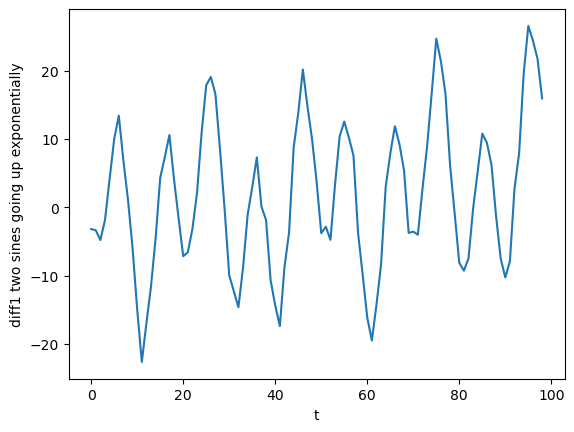

ADF Statistic: -1.954161
p-value: 0.307026
usedlag: 12.000000


In [6]:
diff1_tseries = np.diff(tseries, n=1)

plt.plot(np.arange(0,len(t)-1),diff1_tseries)
plt.xlabel('t')
plt.ylabel('diff1 two sines going up exponentially')
plt.show()

result = adfuller(diff1_tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('usedlag: %f' % result[2])

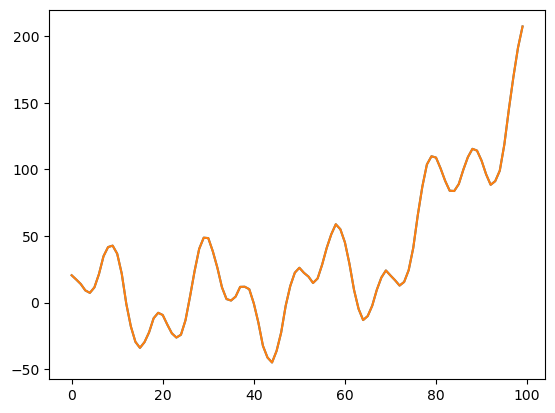

In [7]:
# note:
# to recover a differenced time series use cumsum()
plt.plot(tseries)
plt.plot(np.r_[tseries[0], diff1_tseries].cumsum())
plt.show()

The data still looks non-stationary, which is confirmed by the ADF test. Therefore, we differentiate the data again.

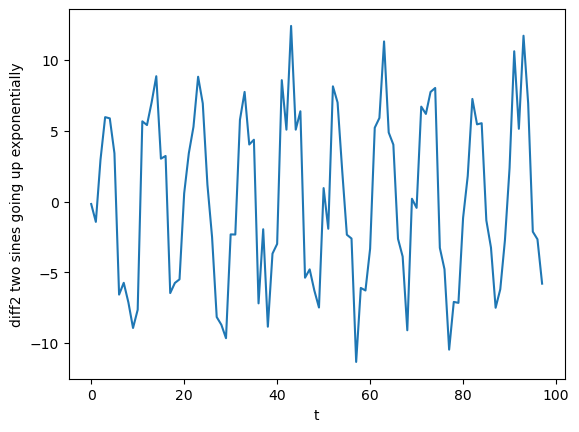

ADF Statistic: -5.966393
p-value: 0.000000
usedlag: 12.000000


In [8]:
diff2_tseries = np.diff(tseries, n=2)

plt.plot(np.arange(0,len(t)-2),diff2_tseries)
plt.xlabel('t')
plt.ylabel('diff2 two sines going up exponentially')
plt.show()

result = adfuller(diff2_tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('usedlag: %f' % result[2])

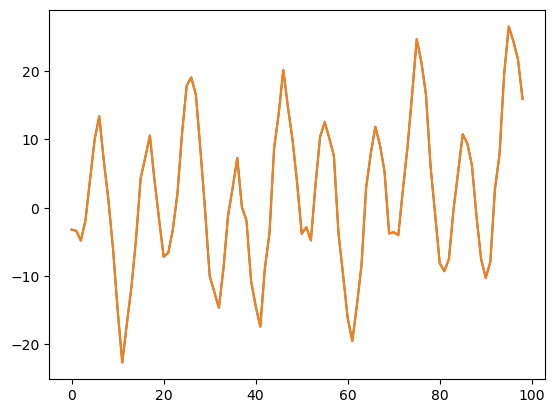

In [9]:
# note:
# to recover a differenced time series use cumsum()
plt.plot(diff1_tseries)
plt.plot(np.r_[diff1_tseries[0], diff2_tseries].cumsum())
plt.show()

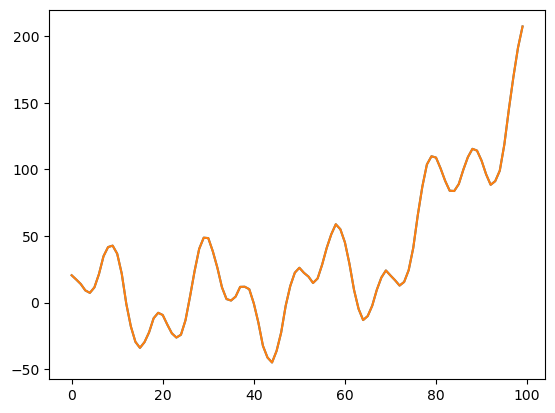

In [10]:
plt.plot(tseries)
plt.plot(np.r_[tseries[0],np.r_[diff1_tseries[0], diff2_tseries].cumsum()].cumsum())
plt.show()

The process can be automated using a loop.

In [11]:

# result = adfuller(tseries)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

Now the data looks stationaty and it is confirmed by the test. So the value for d should be 2. This is in line with the undertlying model that generated our data, which has an exponential trend.

##  Determine the values of p and q

If/once you have a stationary time series, the next step is to select the appropriate ARIMA model. This means finding the most appropriate values for p and q in the ARIMA(p,d,q) model.

(Remember: p refers to how many previous/lagged Y values are accounted for for each time point in our model, and q refers to how many previous/lagged error values are accounted for for each time point in our model. )

To do so, you need to examine the “correlogram” and “partial correlogram” of the stationary time series.

A correlogram shows the AUTOCORRELATION FUNCTION. It’s just like a correlation, except that, rather than correlating two completely different variables, it’s correlating a variable at time t and that same variable at time t-k

A partial correlogram is basically the same thing, except that it removes the effect of shorter autocorrelation lags when calculating the correlation at longer lags. To be more precise, the partial correlation at lag k is the autocorrelation between Yt and Yt-k that is NOT accounted for by the autocorrelations from the 1st to the (k-1)st lags.

For the purposes of this demonstration, let’s get the autocorrelations for the original, non-stationary data as well as the once-differenced, stationary data.

Note that you can specify the maximum number of lags to be shown in the plot by specifying a “lags” value:

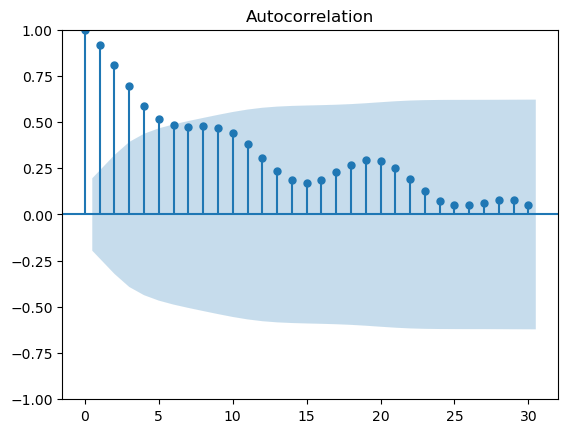

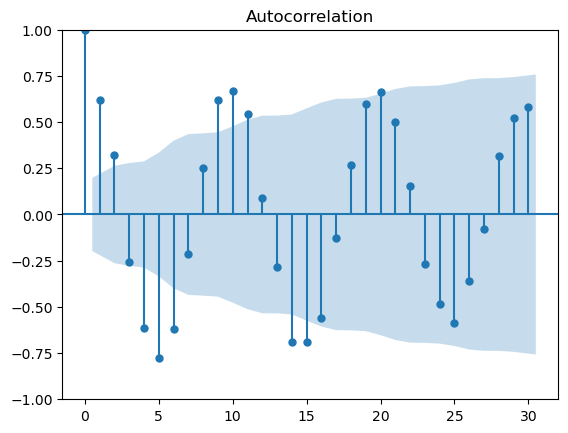

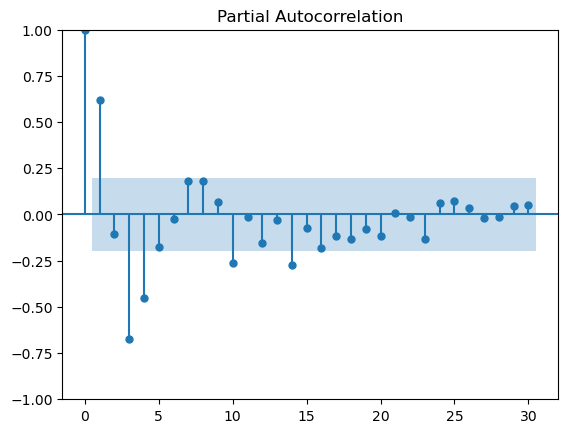

In [12]:
sm.graphics.tsa.plot_acf(tseries, lags=30)
plt.show()

sm.graphics.tsa.plot_acf(diff2_tseries, lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(diff2_tseries, lags=30, method="ywm")
plt.show()

It looks like our times series and the differenced time series repeatedly exceeds the confidence bounds at certain lag points. There’s a recurring pattern involved both in the correlogram and partial correlogram. This is a sign that the data involves some kind of seasonal component, which we need to get rid of before determining the values for p and q.

### 1 st Smoothing noise.

If our data has a lot of noise we can remove this noise using a simply moving average function

In [13]:
# N = 5
# smoothed_diff2_tseries = np.convolve(diff2_tseries, np.ones(N)/N, mode='valid')

# plt.plot(np.arange(0,len(t)-6),smoothed_diff2_tseries)
# plt.xlabel('t')
# plt.ylabel('smoothed diff2 sines')
# plt.show()

### 2. Determine frequency of seasonal patterns. 

The seasonality of the time series can be determined by using the Furier Transform. Which basically extracts the frequency at which patterns in the time series occur.


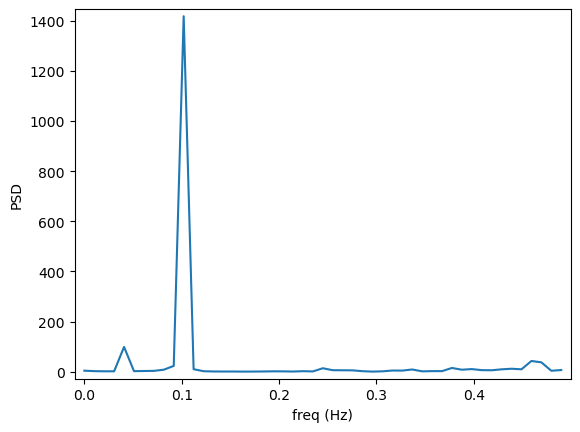

In [14]:
# Determine frequencies
f = np.fft.fftfreq(len(diff2_tseries))

# Compute power spectral density
psd = np.abs(np.fft.fft(diff2_tseries))**2 / len(diff2_tseries)

# Make plot
plt.plot(f[f>=0], psd[f>=0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)

In [15]:
d = {'frequency': f[f>=0], 'psd': psd[f>=0]}
top2 = pd.DataFrame(d).sort_values(by='psd',ascending=False).head(2)
top2

,frequency,psd
10,0.102041,1418.588196
4,0.040816,98.622299


Now we need to convert this frequency to actual time periods by taking the inverse of the frequency.

In [16]:
1 /  round(top2.frequency,2)

10    10.0
4     25.0
Name: frequency, dtype: float64

These values – 25 and 10 – correspond exactly to the original sine waves that we put together. If we recall these functions and the sample intervals, the first (slow) sine wave completed a cycle once every 25 time points, and the second (fast) sine wave completed its cycle once every 10 time points.

### 3. Decomposing data according to its frequency

Now that we’ve determined the frequency of our data, let’s get down to actually decomposing it.

First, we need to make it into a time series where frequency = 10 (as per the results of our Fourier Transform above)–that is to say, where 10 time periods constitute one cycle.

The following code uses the seasonal trend decomposition using Loess method (STL). Basically this methods, extracts the seasonal component of a time series and the trend of the time series after removing the the seasonal component. We must indicate the period of the seasonal pattern to extract, which we obtained before from the Furier Transform. We can use 10 for example, for the short tem seasonal pattern.

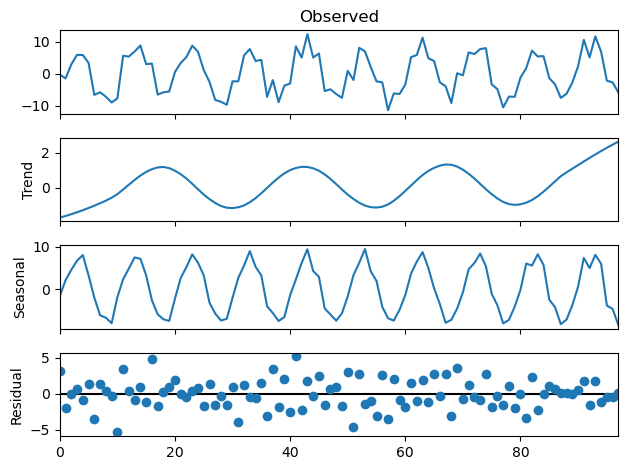

In [17]:
from statsmodels.tsa.seasonal import STL

stl = STL(diff2_tseries, period=10)
res = stl.fit()
fig = res.plot()

From the plot we observe that our trend also follows a sine pattern, this is because of the long term seasonal pattern of the other sine wave. To get rid of both seasonal components and also the trend (which should be flatten due to our differencing process). We can use the multi-seasonal time series decompostion method using loess (MTSL), which is basically the same as the previous approach, but allows us to input more than one seasonal pattern.

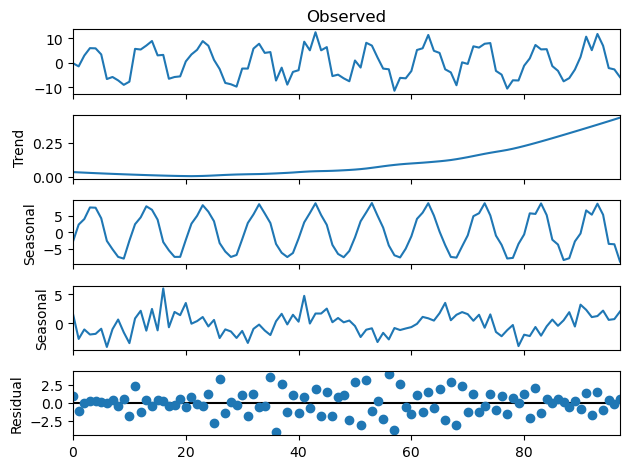

In [18]:
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(diff2_tseries, periods=(10,25))
res2 = mstl.fit()
fig = res2.plot()

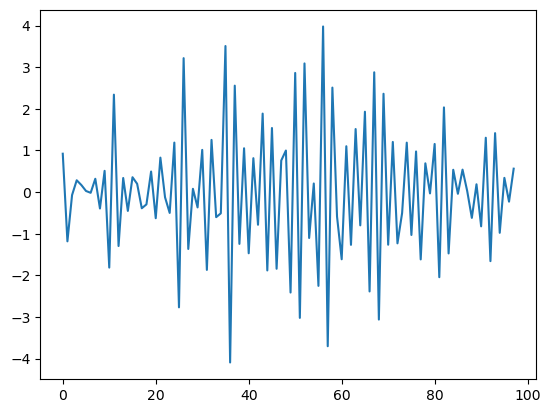

In [19]:
plt.plot(res2.resid)
plt.show()

In [20]:
# X = diff2_tseries
# diff = list()
# season_1= 10
# for i in range(season_1, len(X)):
#     value = X[i] - X[i - season_1]
#     diff.append(value)
# plt.plot(diff)
# plt.show()

In [21]:
# X = diff2_tseries
# diff_2 = list()
# season_2= 25
# for i in range(season_2, len(diff)):
#     value = diff[i] - diff[i - season_2]
#     diff_2.append(value)
# plt.plot(diff_2)
# plt.show()

Now, we can use the correlogram and the partial auto correlogram to determine the values of p and q.

To determine the value of p (AR) we consider the PACP. Every spike outside the confidence interval is a canditate for the value of p. Specially the ones with the largest spike.

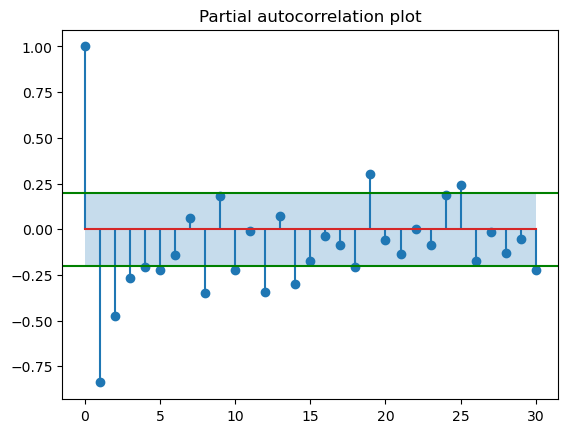

In [22]:
pacf_values = sm.tsa.pacf(res2.resid, nlags=30, method='ywm') # diff_2 or res2.resid

plt.stem(np.arange(0,31),pacf_values)
plt.axhline(2*1/np.sqrt(L),0,1,c='g')
plt.axhline(-2*1/np.sqrt(L),0,1,c='g')
plt.fill_between(np.arange(0,31),2*1/np.sqrt(L),-2*1/np.sqrt(L),alpha=0.25)
plt.title('Partial autocorrelation plot')
plt.show()

In [23]:
potential_p = np.where(np.abs(pacf_values) > 3*1/np.sqrt(L))[0]
potential_p

array([ 0,  1,  2,  8, 12, 19])

To determine the value of q (MA) we consider the ACP. We consider as potential values for q all spikes outside the confidence interval bound.

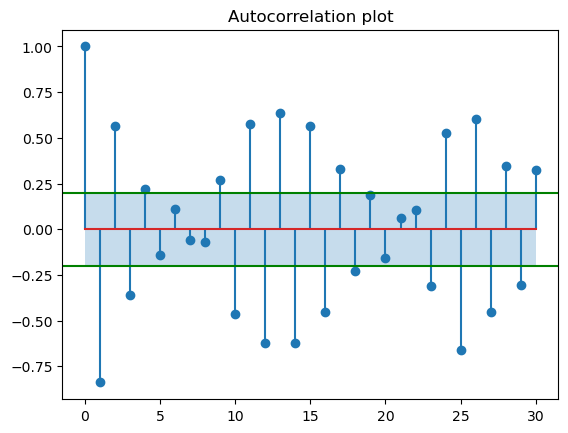

In [24]:
acf_values = sm.tsa.acf(res2.resid, nlags=30) # diff_2 or res2.resid

plt.stem(np.arange(0,31),acf_values)
plt.axhline(2*1/np.sqrt(L),0,1,c='g')
plt.axhline(-2*1/np.sqrt(L),0,1,c='g')
plt.fill_between(np.arange(0,31),2*1/np.sqrt(L),-2*1/np.sqrt(L),alpha=0.25)
plt.title('Autocorrelation plot')
plt.show()

In [25]:
potential_q = np.where(np.abs(acf_values) > 3*1/np.sqrt(L))[0]
potential_q

array([ 0,  1,  2,  3, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 27,
       28, 29, 30])

Based on the previous information we can consider a value of 2 for d. And test a set of values potential_p and potential_q for the the values of p and q. These values can be iteratively tested to find the best ARIMA model.

# AUTO ARIMA ANALYSIS

In [26]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

import warnings
warnings.filterwarnings("ignore")

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [34]:
# # evaluate parameters
# p_values = potential_p
# d_values = np.array([0]) # 0 because we are fitting the model using the differenced data
# q_values = range(0, 3)

# best_cfg = evaluate_models(res2.resid, p_values, d_values, q_values)

In [36]:
# # split into train and test sets
# X = res2.resid
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
#     model = ARIMA(history, order=(best_cfg))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))

# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)

# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

# # to recover the original dataset, the removed seasonal and trend components need to be incorporated again. To do this, one should fit a function to the two removed seasons and trend, and add to the results, and then difference twice back...

## Alternative approach fitting the auto arima apporach directly to original data

In [29]:
# evaluate parameters
p_values = potential_p
d_values = np.array([2])
q_values = range(0, 3)

best_cfg = evaluate_models(tseries, p_values, d_values, q_values)

ARIMA(0, 2, 0) MSE=35.484
ARIMA(0, 2, 1) MSE=24.810
ARIMA(0, 2, 2) MSE=15.909
ARIMA(1, 2, 2) MSE=15.134
ARIMA(2, 2, 2) MSE=5.792
ARIMA(8, 2, 2) MSE=4.534
ARIMA(12, 2, 0) MSE=4.365
ARIMA(12, 2, 2) MSE=4.291
ARIMA(19, 2, 0) MSE=4.119
ARIMA(19, 2, 1) MSE=3.552
ARIMA(19, 2, 2) MSE=3.456
Best ARIMA(19, 2, 2) MSE=3.456


predicted=-3.118163, expected=-2.312177
predicted=6.266134, expected=9.549722
predicted=14.998112, expected=18.774819
predicted=21.908138, expected=24.112700
predicted=22.309273, expected=20.348997
predicted=16.510027, expected=16.782848
predicted=12.353117, expected=12.769297
predicted=14.316582, expected=15.466150
predicted=23.593667, expected=24.358404
predicted=39.625136, expected=40.997405
predicted=62.659208, expected=65.667323
predicted=86.122853, expected=87.062319
predicted=103.427097, expected=103.671650
predicted=110.424575, expected=109.810223
predicted=108.443144, expected=108.854289
predicted=98.240691, expected=100.732670
predicted=89.356177, expected=91.450036
predicted=82.524604, expected=83.971424
predicted=83.725925, expected=83.747383
predicted=88.291652, expected=88.981243
predicted=97.381398, expected=99.753796
predicted=107.883444, expected=109.200107
predicted=112.764221, expected=115.394370
predicted=113.398100, expected=114.078808
predicted=105.188845, expecte

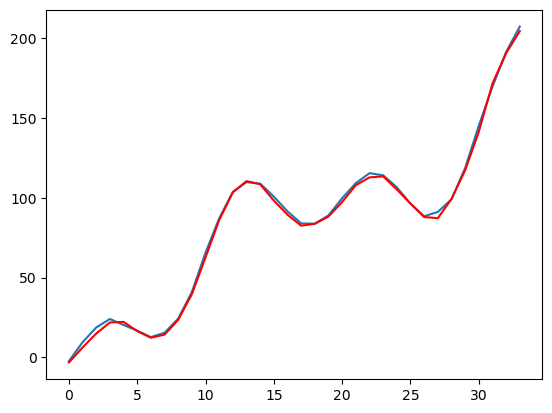

In [30]:
# split into train and test sets
X = tseries
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Alternative approach using TBATS

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [10. 25.]
Seasonal harmonics [1 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): -0.010000
Seasonal Parameters (Gamma): [-1.24066425e-09  2.21878955e-08  1.78139773e-08  1.30307507e-08]
AR coefficients []
MA coefficients []
Seed vector [ 0.0795523  -2.34468745  7.38061328 -0.72741441 -1.84978888]

AIC 394.681566
Test RMSE: 2.651


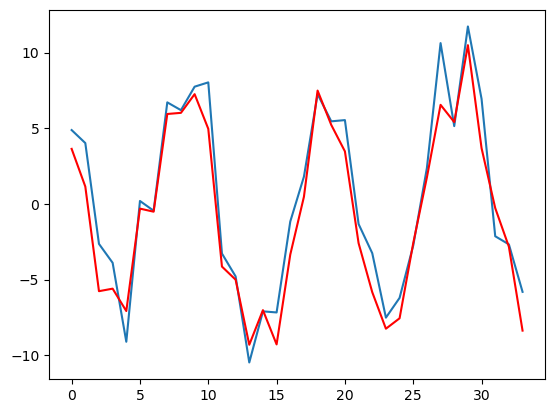

In [119]:
from tbats import TBATS

X = diff2_tseries
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# Create estimator
estimator = TBATS(seasonal_periods=[10, 25],use_trend=False, use_arma_errors=False,use_box_cox=True)

# Fit model
fitted_model = estimator.fit(train)

# Forecast 14 steps ahead
y_forecasted = fitted_model.forecast(steps=len(test))

# Summarize fitted model
print(fitted_model.summary())

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, y_forecasted))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

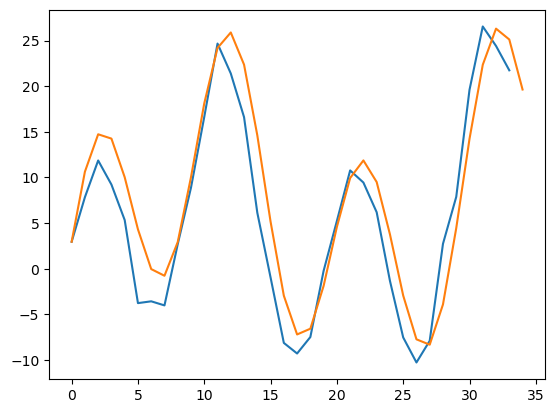

In [120]:
plt.plot(diff1_tseries[size:len(X)])
plt.plot(np.r_[diff1_tseries[size], y_forecasted].cumsum())
plt.show()

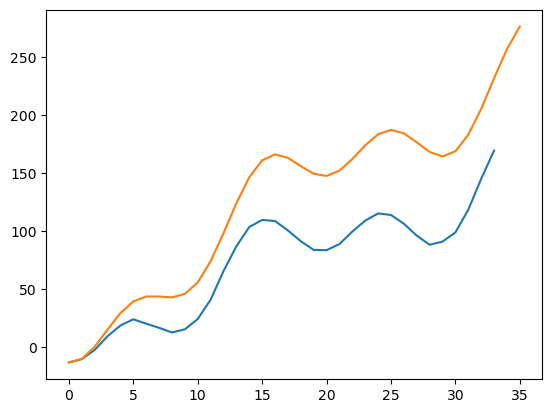

In [121]:
plt.plot(tseries[size:len(X)])
plt.plot(np.r_[tseries[size],np.r_[diff1_tseries[size], y_forecasted].cumsum()].cumsum())
plt.show()